In [1]:
import os
import pandas as pd
import numpy as np
import yaml
import logging
import pickle
from sklearn.metrics import r2_score
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

if not os.path.exists('Figures/exposure_function') :
    os.makedirs('Figures/exposure_function')

In [3]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_oecd, ac_data_gdl, ac_data_eia])

ac_data = add_gdp_cdd_data(ac_data, config)

ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the latest one
ac_data = ac_data.drop_duplicates('ISO3', keep='last')
ac_data = ac_data.dropna()

# Save the data to a csv file
ac_data.to_csv("air_conditioning_data.csv")

# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1e3, ac_data["GDP"]/1e6)
ydata = ac_data["AC"]


In [4]:
# Functional form of AC access as proposed in this study
def ac_access_combined_exp(xdata, a, b, c):
    cdd, gdp = xdata
    return (1. - np.exp(-a * ((cdd)**(b*gdp) * (gdp)**c)))

In [5]:
def r2_step_by_step(ydata, ymodel):
    """
    Calculate R2 step by step
    """
    ss_res = np.sum((ydata - ymodel)**2)
    ss_tot = np.sum((ydata - np.mean(ydata))**2)
    r2_step = 1 - ss_res/ss_tot
    return r2_step

def compute_log_likelihood(rss, n):
    """
    Compute the log likelihood function
    """
    s = np.sqrt(rss / n)
    llf = - n/2 * np.log(2 * np.pi) - \
            n * np.log(s) - 1/(2 * s**2) * rss
    return llf

def computeAIC(ydata, ymodel, k):
    """
    Compute the Akaike Information Criterion
    """
    n = len(ydata)
    rss = np.sum((ydata - ymodel)**2)
    aic = -2 * compute_log_likelihood(rss, n) + 2 * k
    # Bias correction
    aic += 2 * k * (k + 1) / (n - k - 1)
    return aic

def t_test(ydata, params, cov):
    """
    Perform a t-test on the model
    """
    stderr = np.sqrt(np.diag(cov))
    t_vals = params / stderr
    df = len(ydata) - len(params)
    p_vals = [2 * (1 - t.cdf(np.abs(t_val), df)) for t_val in t_vals]
    return t_vals, p_vals

In [6]:
def fit_diagnostics(ydata, ymodel, params, cov, funct_name=''):
    """
    Calculate R2 with function and step by step
    """
    print("Fit diagnostics for ", funct_name)
    r2 = r2_score(ydata, ymodel)
    print("R^2: ", r2)
    
    r2_step = r2_step_by_step(ydata, ymodel)
    print("R^2 step-by-step: ", r2_step)

    if cov is not None:
        t_values, p_values = t_test(ydata, params, cov)
        print("t-values", t_values)
        print("p-values", p_values)

    aic = computeAIC(ydata, ymodel, len(params))
    print("AIC: ", aic)

In [7]:
# Plot AC access data vs model
def plot_ac_access(ydata, ymodel, color, title, filename):
    plt.figure()
    plt.scatter(ydata, ymodel, color=color)
    plt.plot([0.001, 1], [0.001, 1], color='gray', linestyle='--')
    # Both axes in log scale
    plt.xscale('log')
    plt.yscale('log')
    # Set the limits of the axes
    plt.xlim([0.001, 1])
    plt.ylim([0.001, 1])
    # Add labels
    plt.xlabel("AC access data")
    plt.ylabel("AC access model")
    plt.title(title)
    plt.savefig("Figures/exposure_function/{0}.png".format(filename))

Fit parameters for AC access combined exponential
alpha =  54.939563054505655 beta =  8.765157631850807 gamma =  1.2779354448682456 

Fit diagnostics for  AC access combined exponential
R^2:  0.5411568331517178
R^2 step-by-step:  0.5411568331517178
t-values [1.48567709 3.24413621 7.32975443]
p-values [0.14167056461899374, 0.0017784048744653447, 2.537217103082412e-10]
AIC:  -59.66167556464651


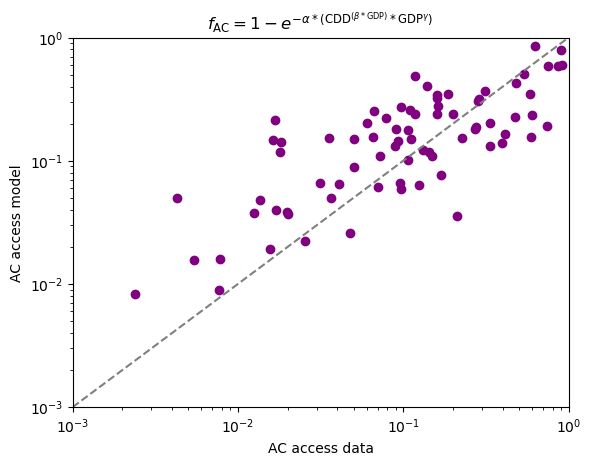

In [8]:
# Fit with new function
popt_comb, pcov_comb = curve_fit(ac_access_combined_exp, xdata, ydata, bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential")
print("alpha = ", popt_comb[0], "beta = ", popt_comb[1], "gamma = ", popt_comb[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(ydata, ac_access_combined_exp(xdata, *popt_comb), popt_comb, pcov_comb, "AC access combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (ac_access_combined_exp(xdata, *popt_comb)), "purple", r"$f_{\mathrm{AC}}=1 - e^{-\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})}$", "ac_access_combined_exp")

with open('exposure_function_params_combined_exponential.pkl', 'wb') as f:
    pickle.dump({'alpha': popt_comb[0], 'beta': popt_comb[1], 'gamma': popt_comb[2]}, f)

Fit parameters for AC access combined exponential
alpha =  42.577084381540274 beta =  7.970007253965869 gamma =  1.297046928447517 

Fit diagnostics for  AC access log of combined exponential
R^2:  0.6002285953572024
R^2 step-by-step:  0.6002285953572024
t-values [1.53487017 1.95433247 9.65525692]
p-values [0.12913870911340064, 0.05449245222559651, 1.1102230246251565e-14]
AIC:  201.62513623673868


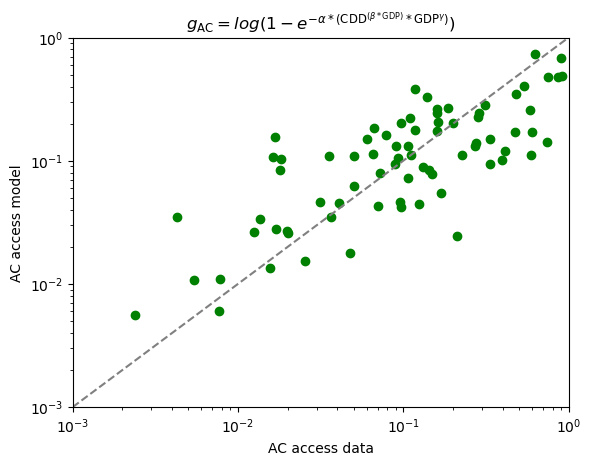

In [11]:
# Repeat the fit with the log of the function

def ac_access_combined_exp_log(xdata, a, b, c):
    return np.log(ac_access_combined_exp(xdata, a, b, c))

popt_comb_log, pcov_comb_log = curve_fit(ac_access_combined_exp_log, xdata, np.log(ydata), bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential")
print("alpha = ", popt_comb_log[0], "beta = ", popt_comb_log[1], "gamma = ", popt_comb_log[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(np.log(ydata), ac_access_combined_exp_log(xdata, *popt_comb_log), popt_comb_log, pcov_comb_log, "AC access log of combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (np.exp(ac_access_combined_exp_log(xdata, *popt_comb_log))), "green", r"$g_{\mathrm{AC}}= log(1 - e^{-\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})})$", "ac_access_combined_exp")


In [12]:
# Repeat the fit with the double log of the function

def ac_access_combined_exp_log_log(xdata, a, b, c):
    return np.log(np.log(ac_access_combined_exp(xdata, a, b, c)))
print(np.log(np.log(ydata)))
popt_comb_log_log, pcov_comb_log_log = curve_fit(ac_access_combined_exp_log_log, xdata, np.log(np.log(ydata)), bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential")
print("alpha = ", popt_comb_log_log[0], "beta = ", popt_comb_log_log[1], "gamma = ", popt_comb_log_log[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(np.log(np.log(ydata)), ac_access_combined_exp_log_log(xdata, *popt_comb_log_log), popt_comb_log_log, pcov_comb_log_log, "AC access double log of combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (np.exp(np.exp(ac_access_combined_exp_log_log(xdata, *popt_comb_log_log)))), "blue", r"$h_{\mathrm{AC}}= log(log(1 - e^{-\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})}))$", "ac_access_combined_exp")

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: array must not contain infs or NaNs